# Optimality of TD 0

In this notebook we will explore how batch TD(0) compares to constant-$\alpha$ MC on the random walk scenario.

## Here's what the environment looks like:

In [1]:
%load_ext tikzmagic
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np

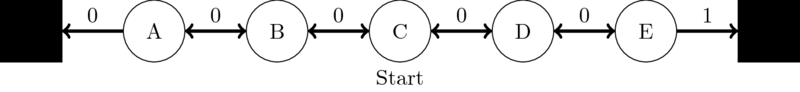

In [2]:
%%tikz -s 800,800
\filldraw (-6.5,-0.5) rectangle (-5.5,0.5);
\draw[line width=1.5,->] (-4.5,0) -- (-5.5,0);
\draw (-5,0.25) node {0};
\draw (-4,0) circle (0.5);
\draw (-4,0) node {A};
\draw[line width=1.5,<->] (-3.5,0) -- (-2.5,0);
\draw (-3,0.25) node {0};
\draw (-2,0) circle (0.5);
\draw (-2,0) node {B};
\draw[line width=1.5,<->] (-1.5,0) -- (-0.5,0);
\draw (-1,0.25) node {0};
\draw (0,0) circle (0.5);
\draw (0,0) node {C};
\draw (0,-0.75) node {Start};
\draw[line width=1.5,<->] (0.5,0) -- (1.5,0);
\draw (1,0.25) node {0};
\draw (2,0) circle (0.5);
\draw (2,0) node {D};
\draw[line width=1.5,<->] (2.5,0) -- (3.5,0);
\draw (3,0.25) node {0};
\draw (4,0) circle (0.5);
\draw (4,0) node {E};
\draw (5,0.25) node {1};
\draw[line width=1.5,->] (4.5,0) -- (5.5,0);
\filldraw (5.5,-0.5) rectangle (6.5,0.5);

In [25]:
def TD0(alpha = 0.1, batch=False, E=101, seed=None):
    if seed:
        np.random.seed(seed) # optional, just useful for consistent debugging
    V = np.zeros(7) + 0.5
    V[0] = 0
    V[6] = 0
    V_s = []
    episodes = []
    for i in range(E):
        V_s.append(deepcopy(V[1:6]))

        episode = []
        
        # Reprocess previous episodes
        if batch:
            for episode in episodes:
                updates = np.zeros(7)
                for s, reward, s_ in episode:
                    updates[s] += alpha * (reward + V[s_] - V[s])
                for i in range(6):
                    V[i] += updates[i];
                    
        updates = np.zeros(7)
        s = 3 # Always start at "C"
        while True:
            s_ = s + np.random.choice([-1,1])
            
            if s_ == 6:
                reward = 1
            else:
                reward = 0
            
            episode.append((s, reward, s_))
            
            if batch:
                updates[s] += alpha * (reward + V[s_] - V[s])
            else:
                V[s] = (1-alpha) * V[s] + alpha * (reward + V[s_])

            s = s_

            if s == 6 or s == 0:
                if batch:
                    for i in range(6):
                        V[i] += updates[i];
                break
                
        episodes.append(episode)
    return V_s

## Replicating figure 6.6

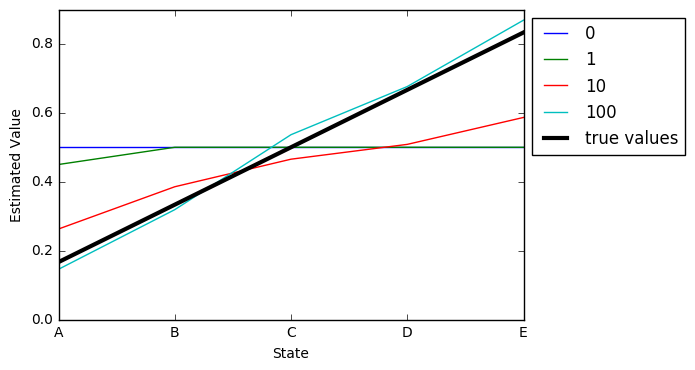

In [7]:
V_s = TD0(seed=9)
for i in [0, 1, 10, 100]:
    plt.plot(V_s[i], label=str(i))
plt.plot([1/6, 2/6, 3/6, 4/6, 5/6], label="true values", linewidth=3, color='black')
plt.xticks([0,1,2,3,4], ["A", "B", "C", "D", "E"])
plt.yticks([0,0.2,0.4,0.6,0.8])
plt.xlabel("State")
plt.ylabel("Estimated Value")
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.show()

## Replicating Figure 6.7

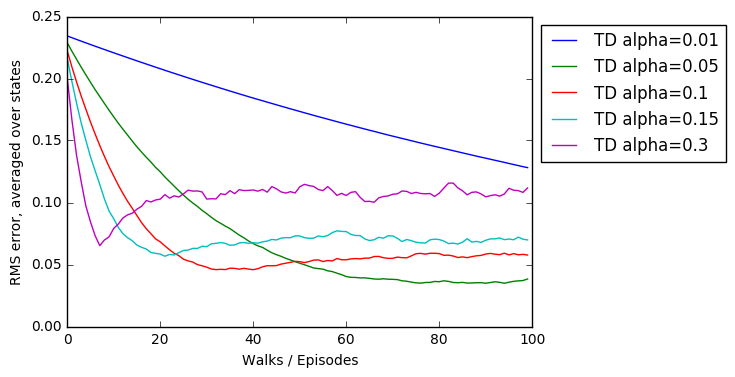

In [38]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

true_V = [1/6, 2/6, 3/6, 4/6, 5/6]
for alpha in [0.01, 0.05, 0.1, 0.15, 0.3]:
    errors = np.zeros(100)
    for i in range(100):
        V_s = TD0(alpha)[1:] # skip 0th episode
        for i, V in enumerate(V_s):
            error = rmse(V, true_V)
            errors[i] += error/100
    plt.plot(errors, label="TD alpha={}".format(alpha))
plt.xlabel("Walks / Episodes")
plt.ylabel("RMS error, averaged over states")
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.show()

## Replicating figure 6.8

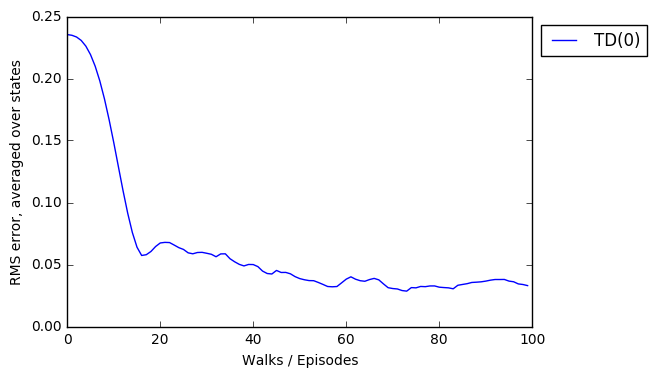

In [34]:
# Batch MC


# Batch TD(0)
errors = np.zeros(100)
trails = 10
for i in range(trails):
    V_s = TD0(alpha=0.002, batch=True)[1:] # skip 0th episode
    for i, V in enumerate(V_s):
        error = rmse(V, true_V)
        errors[i] += error/trails
plt.plot(errors, label="TD(0)")
plt.xlabel("Walks / Episodes")
plt.ylabel("RMS error, averaged over states")
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.show()